**PyTorch implementation of Conv-6 for CIFAR-10 classification**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(f'\nAvailable device is {device}')


Available device is cuda


In [4]:
# Hyper-parameters-
num_epochs = 16
batch_size = 32
learning_rate = 0.0003

In [5]:
# Dataset has PILImage images of range [0, 1]. We transform them to Tensors
# of normalized range [-1, 1]
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )

In [6]:
# Load dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = True,
        download = True, transform = transform
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = False,
        download = True, transform = transform
        )

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [8]:
print(f"Sizes of train_dataset: {len(train_dataset)} and test_dataet: {len(test_dataset)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 50000 and test_dataet: 10000
Sizes of train_loader: 1563 and test_loader: 313


After defining dataset and dataloader, we can do automatic batch optimization and batch training

In [9]:
# Define CIFAR-10 classes-
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
        'ship', 'truck')

In [ ]:
def show_some_imgs(img):
    # De-normalize img-
    img = img / 2 * 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

    return None

In [ ]:
# Get some random training images-
some_img = iter(train_loader)
images, labels = some_img.next()

# You get 32 images due to our specified batch size-
images.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


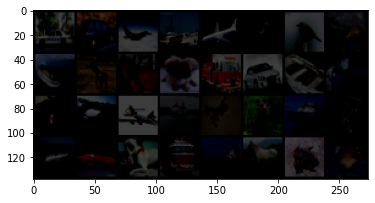

In [ ]:
# Visualize these random images-
show_some_imgs(torchvision.utils.make_grid(images))

In [10]:
class cnn_block(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(cnn_block, self).__init__()

    # Define layers-
    self.conv1 = nn.Conv2d(
        in_channels = input_channels, out_channels = output_channels,
        kernel_size = 3, stride = 1,
        padding = 1, bias = True
    )
    self.conv2 = nn.Conv2d(
        in_channels = output_channels, out_channels = output_channels,
        kernel_size = 3, stride = 1,
        padding = 1, bias = True
    )
    self.pool = nn.MaxPool2d(
        kernel_size = 2, stride = 2
    )
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    return self.pool(x)


In [11]:
class Conv6(nn.Module):
  def __init__(self):
    super(Conv6, self).__init__()

    self.block1 = cnn_block(input_channels = 3, output_channels = 64)
    self.block2 = cnn_block(input_channels = 64, output_channels = 128)
    self.block3 = cnn_block(input_channels = 128, output_channels = 256)

    self.fc1 = nn.Linear(
        in_features = 256 * 4 * 4, out_features = 256,
        bias = True
    )
    self.fc2 = nn.Linear(
        in_features = 256, out_features = 256,
        bias = True
    )
    self.op_layer = nn.Linear(
        in_features = 256, out_features = 10,
        bias = True
    )
    

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.op_layer(x)
    


In [22]:
# Instantiate an instance of CNN model-
model = Conv6().to(device)

In [ ]:
# Count number of trainable parameters per layer-
tot_params = 0
for layer in model.parameters():
  print(f"layer.shape: {layer.shape} has {layer.nelement()} parameters")
  tot_params += layer.nelement()

layer.shape: torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape: torch.Size([64]) has 64 parameters
layer.shape: torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape: torch.Size([64]) has 64 parameters
layer.shape: torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape: torch.Size([128]) has 128 parameters
layer.shape: torch.Size([128, 128, 3, 3]) has 147456 parameters
layer.shape: torch.Size([128]) has 128 parameters
layer.shape: torch.Size([256, 128, 3, 3]) has 294912 parameters
layer.shape: torch.Size([256]) has 256 parameters
layer.shape: torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape: torch.Size([256]) has 256 parameters
layer.shape: torch.Size([256, 4096]) has 1048576 parameters
layer.shape: torch.Size([256]) has 256 parameters
layer.shape: torch.Size([256, 256]) has 65536 parameters
layer.shape: torch.Size([256]) has 256 parameters
layer.shape: torch.Size([10, 256]) has 2560 parameters
layer.shape: torch.Size([10]) has 10 parameters


In [ ]:
print(f"Conv-6 CNN has {tot_params} parameters.")

Conv-6 CNN has 2262602 parameters.


In [23]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [14]:
num_training_steps = len(train_loader)

In [15]:
print(f"number of training steps in one epoch = {num_training_steps}")

number of training steps in one epoch = 1563


In [ ]:
# Sanity check before training model-
images.shape

torch.Size([32, 3, 32, 32])

In [ ]:
y_pred = model(images)
y_pred.shape

torch.Size([32, 10])

In [ ]:
_, predicted = torch.max(y_pred, 1)
predicted.shape

torch.Size([32])

In [24]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [25]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [26]:
# Python3 lists to store model training metrics-
training_acc = []
validation_acc = []
training_loss = []
validation_loss = []

In [27]:
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    running_loss_val = 0.0
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    
    
    for batch, (images, labels) in enumerate(train_loader):
        # Attempt to push to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        model.train()

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # does backprop

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_training_steps}, loss = {J.item():.4f}")
        '''

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    # print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%\n")

    total = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            images = images.to(device)
            labels = labels.to(device)
            # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)
    print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

    # Code for manual Early Stopping:
    if np.abs(epoch_val_loss < best_val_loss) >= minimum_delta:
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = epoch_val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement


    training_acc.append(epoch_acc * 100)
    validation_acc.append(val_acc)
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)



epoch: 1 training loss = 1.5563, training accuracy = 41.66%, val_loss = 1.1760 & val_accuracy = 57.02%


epoch: 2 training loss = 1.0303, training accuracy = 63.09%, val_loss = 0.9131 & val_accuracy = 67.38%


epoch: 3 training loss = 0.7609, training accuracy = 73.23%, val_loss = 0.7337 & val_accuracy = 74.86%


epoch: 4 training loss = 0.5959, training accuracy = 79.17%, val_loss = 0.6425 & val_accuracy = 77.81%


epoch: 5 training loss = 0.4726, training accuracy = 83.41%, val_loss = 0.6126 & val_accuracy = 79.21%


epoch: 6 training loss = 0.3590, training accuracy = 87.53%, val_loss = 0.6315 & val_accuracy = 79.92%


epoch: 7 training loss = 0.2685, training accuracy = 90.56%, val_loss = 0.7512 & val_accuracy = 78.35%


epoch: 8 training loss = 0.1906, training accuracy = 93.29%, val_loss = 0.7229 & val_accuracy = 79.92%


'EarlyStopping' called!



In [28]:
print("\nFinished training Conv-6 CNN model\n")


Finished training Conv-6 CNN model



In [ ]:
# print(model)

In [29]:
# Variables for computing model metrics-
total = 0
correct = 0

In [30]:
# Evaluate trained CNN model. We don't want these operations to be tracked in
# the computational graph. Hence wrap these operations in-
with torch.no_grad():
  for images, labels in test_loader:

    # Place features (images) and targets (labels) to GPU-
    images = images.to(device)
    labels = labels.to(device)
    # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

    # Make predictions using trained model-
    outputs = model(images)
    _, y_pred = torch.max(outputs, 1)
    
    # Total number of labels-
    total += labels.size(0)

    # Total number of correct predictions-
    correct += (y_pred == labels).sum()

  val_acc = 100 * (correct / total)
  print(f"Conv-6 trained CNN's validation metrics are:")
  print(f"accuracy = {val_acc:.2f}%, # of correct labels = {correct} & total # of labels = {total}")



Conv-6 trained CNN's validation metrics are:
accuracy = 79.92%, # of correct labels = 7992 & total # of labels = 10000


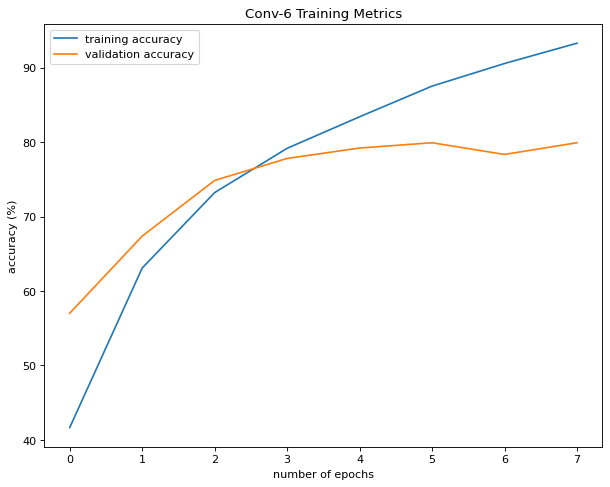

In [31]:
# Visualize training metrics-
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(np.asarray(training_acc), label = 'training accuracy')
plt.plot(np.asarray(validation_acc), label = 'validation accuracy')

plt.title("Conv-6 Training Metrics")
plt.xlabel("number of epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()


In [ ]:
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(np.asarray(training_loss), label = 'training loss')
plt.plot(np.asarray(validation_loss), label = 'validation loss')

plt.title("Conv-6 Training Metrics")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config', 'data', 'Conv6_Trained.pth', 'sample_data']

In [ ]:
for layer in model.state_dict().keys():
  print(f"{layer} has shape: {model.state_dict()[layer].shape}")

block1.conv1.weight has shape: torch.Size([64, 3, 3, 3])
block1.conv1.bias has shape: torch.Size([64])
block1.conv2.weight has shape: torch.Size([64, 64, 3, 3])
block1.conv2.bias has shape: torch.Size([64])
block2.conv1.weight has shape: torch.Size([128, 64, 3, 3])
block2.conv1.bias has shape: torch.Size([128])
block2.conv2.weight has shape: torch.Size([128, 128, 3, 3])
block2.conv2.bias has shape: torch.Size([128])
block3.conv1.weight has shape: torch.Size([256, 128, 3, 3])
block3.conv1.bias has shape: torch.Size([256])
block3.conv2.weight has shape: torch.Size([256, 256, 3, 3])
block3.conv2.bias has shape: torch.Size([256])
fc1.weight has shape: torch.Size([256, 4096])
fc1.bias has shape: torch.Size([256])
fc2.weight has shape: torch.Size([256, 256])
fc2.bias has shape: torch.Size([256])
op_layer.weight has shape: torch.Size([10, 256])
op_layer.bias has shape: torch.Size([10])


In [33]:
# Save trained model-
torch.save(model.state_dict(), '/content/Conv6_Trained.pth')

In [ ]:
# Instantiate a new model and load weights-
test_model = Conv6().to(device)

In [ ]:
# Load saved and pre-trained model-
if torch.cuda.is_available():
    test_model.load_state_dict(torch.load('Conv6_Trained.pth'))
else:
    test_model.load_state_dict(torch.load('Conv6_Trained.pth', map_location=torch.device('cpu')))

In [ ]:
# Set the loaded model to evaluation mode-
test_model.eval()

Conv6(
  (block1): cnn_block(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): cnn_block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): cnn_block(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (op_layer): Linear(in_features=256, out_feat

In [ ]:
total = 0
correct = 0

In [ ]:
# Evaluate loaded CNN model. We don't want these operations to be tracked in
# the computational graph. Hence wrap these operations in-
with torch.no_grad():
  for images, labels in test_loader:

    # Place features (images) and targets (labels) to GPU-
    images = images.to(device)
    labels = labels.to(device)
    # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

    # Make predictions using trained model-
    outputs = test_model(images)
    _, y_pred = torch.max(outputs, 1)
    
    # Total number of labels-
    total += labels.size(0)

    # Total number of correct predictions-
    correct += (y_pred == labels).sum()

  val_acc = 100 * (correct / total)
  print(f"Conv-6 trained CNN's validation metrics are:")
  print(f"accuracy = {val_acc:.2f}%, # of correct labels = {correct} & total # of labels = {total}")



Conv-6 trained CNN's validation metrics are:
accuracy = 78.57%, # of correct labels = 7857 & total # of labels = 10000


In [ ]:
test_model.parameters()

<generator object Module.parameters at 0x7f5f86bd76d0>

In [ ]:
for layer in test_model.state_dict().keys():
    print(f"layer: {layer} has shape: {test_model.state_dict()[layer].shape}")
    '''
    if len(test_model.state_dict()[layer].shape) > 1:
        print(f"layer: {layer} has shape: {test_model.state_dict()[layer].shape}")
    '''

layer: block1.conv1.weight has shape: torch.Size([64, 3, 3, 3])
layer: block1.conv1.bias has shape: torch.Size([64])
layer: block1.conv2.weight has shape: torch.Size([64, 64, 3, 3])
layer: block1.conv2.bias has shape: torch.Size([64])
layer: block2.conv1.weight has shape: torch.Size([128, 64, 3, 3])
layer: block2.conv1.bias has shape: torch.Size([128])
layer: block2.conv2.weight has shape: torch.Size([128, 128, 3, 3])
layer: block2.conv2.bias has shape: torch.Size([128])
layer: block3.conv1.weight has shape: torch.Size([256, 128, 3, 3])
layer: block3.conv1.bias has shape: torch.Size([256])
layer: block3.conv2.weight has shape: torch.Size([256, 256, 3, 3])
layer: block3.conv2.bias has shape: torch.Size([256])
layer: fc1.weight has shape: torch.Size([256, 4096])
layer: fc1.bias has shape: torch.Size([256])
layer: fc2.weight has shape: torch.Size([256, 256])
layer: fc2.bias has shape: torch.Size([256])
layer: op_layer.weight has shape: torch.Size([10, 256])
layer: op_layer.bias has shape:

In [ ]:
modified_wts = {}
for layer in test_model.state_dict().keys():
    modified_wts[layer] = test_model.state_dict()[layer]

In [ ]:
for layer in modified_wts.keys():
    print(layer, modified_wts[layer].shape)

block1.conv1.weight torch.Size([64, 3, 3, 3])
block1.conv1.bias torch.Size([64])
block1.conv2.weight torch.Size([64, 64, 3, 3])
block1.conv2.bias torch.Size([64])
block2.conv1.weight torch.Size([128, 64, 3, 3])
block2.conv1.bias torch.Size([128])
block2.conv2.weight torch.Size([128, 128, 3, 3])
block2.conv2.bias torch.Size([128])
block3.conv1.weight torch.Size([256, 128, 3, 3])
block3.conv1.bias torch.Size([256])
block3.conv2.weight torch.Size([256, 256, 3, 3])
block3.conv2.bias torch.Size([256])
fc1.weight torch.Size([256, 4096])
fc1.bias torch.Size([256])
fc2.weight torch.Size([256, 256])
fc2.bias torch.Size([256])
op_layer.weight torch.Size([10, 256])
op_layer.bias torch.Size([10])


In [ ]:
new_model = Conv6()

In [ ]:
new_model.load_state_dict(modified_wts)

<All keys matched successfully>

In [ ]:
new_model.eval()

Conv6(
  (block1): cnn_block(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): cnn_block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): cnn_block(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (op_layer): Linear(in_features=256, out_feat

In [ ]:
total = 0
correct = 0

In [ ]:
# Evaluate loaded CNN model. We don't want these operations to be tracked in
# the computational graph. Hence wrap these operations in-
with torch.no_grad():
  for images, labels in test_loader:

    # Place features (images) and targets (labels) to GPU-
    images = images.to(device)
    labels = labels.to(device)
    # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

    # Make predictions using trained model-
    outputs = new_model(images)
    _, y_pred = torch.max(outputs, 1)
    
    # Total number of labels-
    total += labels.size(0)

    # Total number of correct predictions-
    correct += (y_pred == labels).sum()

  val_acc = 100 * (correct / total)
  print(f"Conv-6 trained CNN's validation metrics are:")
  print(f"accuracy = {val_acc:.2f}%, # of correct labels = {correct} & total # of labels = {total}")



Conv-6 trained CNN's validation metrics are:
accuracy = 78.57%, # of correct labels = 7857 & total # of labels = 10000
